In [4]:
from __future__ import print_function, division
from builtins import range, input

# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.resnet import ResNet50, preprocess_input

# from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

from glob import glob


# re-size all the images to this
IMAGE_SIZE = [100, 100]  # feel free to change depending on dataset

# training config:
epochs = 16
batch_size = 32

train_path = "../data/processed/train"
valid_path = "../data/processed/val"

# useful for getting number of files
image_files = glob(train_path + "/*/*.jp*g")
valid_image_files = glob(valid_path + "/*/*.jp*g")

# useful for getting number of classes
folders = glob(train_path + "/*")

In [ ]:
plt.imshow(image.load_img(np.random.choice(image_files)))
# plt.show()

In [ ]:
# add preprocessing layer to the front of ResNet50
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights="imagenet", include_top=False)

# don't train existing weights
for layer in res.layers:
    layer.trainable = False

# our layers - you can add more if you want
x = Flatten()(res.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation="softmax")(x)


# create a model object
model = Model(inputs=res.input, outputs=prediction)

# view the structure of the model
model.summary()

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
    loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"]
)


# create an instance of ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input,
)


# test generator to see how it works and some other useful things

# get label mapping for confusion matrix plot later
test_gen = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_gen:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [ ]:
# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)
valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    shuffle=True,
    batch_size=batch_size,
)

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

model_path = "../models/resnet50_model.keras"
model.save(model_path)
print(f"Model saved to: {os.path.abspath(model_path)}")

In [ ]:
def get_confusion_matrix(data_path, N):
    # we need to see the data in the same order
    # for both predictions and targets
    print("Generating confusion matrix", N)
    predictions = []
    targets = []
    i = 0
    for x, y in gen.flow_from_directory(
        data_path, target_size=IMAGE_SIZE, shuffle=False, batch_size=batch_size * 2
    ):
        i += 1
        if i % 50 == 0:
            print(i)
        p = model.predict(x)
        p = np.argmax(p, axis=1)
        y = np.argmax(y, axis=1)
        predictions = np.concatenate((predictions, p))
        targets = np.concatenate((targets, y))
        if len(targets) >= N:
            break

    cm = confusion_matrix(targets, predictions)
    return cm

In [ ]:
cm = get_confusion_matrix(train_path, len(image_files))
print(cm)
valid_cm = get_confusion_matrix(valid_path, len(valid_image_files))
print(valid_cm)

In [ ]:
# plot some data

# loss
plt.plot(r.history["loss"], label="train loss")
plt.plot(r.history["val_loss"], label="val loss")
plt.legend()
# plt.show()

In [ ]:
# accuracies
plt.plot(r.history["accuracy"], label="train acc")
plt.plot(r.history["val_accuracy"], label="val acc")
plt.legend()
# plt.show()

Confusion matrix, without normalization
[[331  91]
 [ 98 373]]


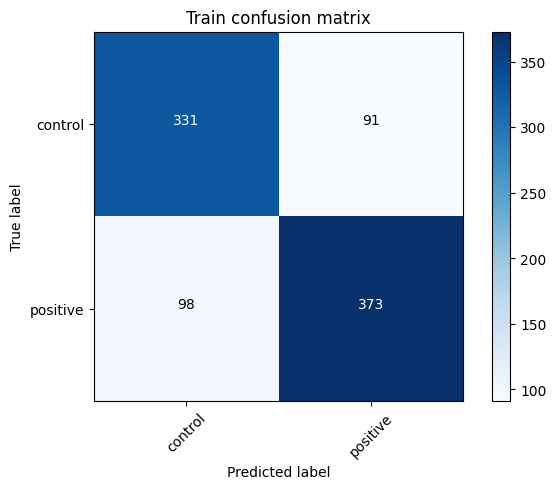

Confusion matrix, without normalization
[[68 14]
 [34 75]]


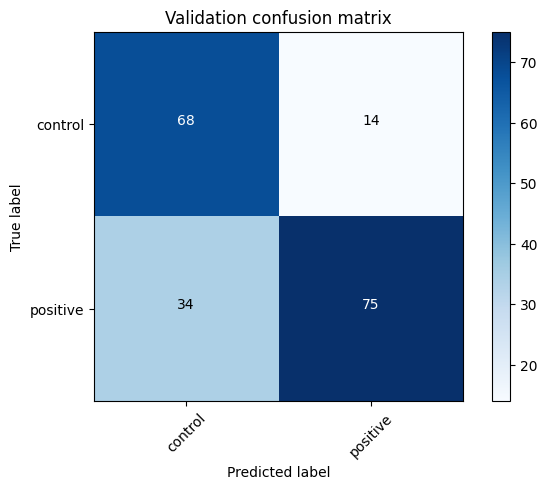

In [24]:
sys.path.append(os.path.abspath('../utils'))
from util import plot_confusion_matrix

plot_confusion_matrix(cm, labels, title="Train confusion matrix")
plot_confusion_matrix(valid_cm, labels, title="Validation confusion matrix")